# Called Third Strike
### _Building a Strike Probability Model_
<div>
<img src="resources/baseball_umpire_home_plate_1.jpg" width="600"/>
</div>

---
## Part 7. Produce Strike Probabilities

This project's goal is to build probability models for as to whether a pitch will be called a strike or not. The intended models are to be:
1. A neural network (NN) based approach.
2. A non-NN based approach.

---

__**This Notebook's**__ objective is to produce the following deliverables:
- Strike probabilities for test set data as predicted by the selected [neural network model](./05_improved_neural_network.ipynb).
- Strike probabilities for test set data as predicted by the selected non-neural network model, in this case [an XGBoost model](./06_improved_non_nn_model.ipynb).


- Deliverables files will be `.csv`s with 2 fields:
    - `pitch_id`
    - `probability of a strike`


The majority of the content here will be reproductions from the [neural network notebook](./05_improved_neural_network.ipynb) and the [XGBoost notebook](./06_improved_non_nn_model.ipynb), but I wanted to unify it here for easier reference. 

---
---

### Table of Contents<a id='7_toc'></a>

<a href='#7_data'>1. Data Preparation</a>

<a href='#7_nn_pred'>2. Predictions - Neural Network</a>

<a href='#7_xgb_pred'>3. Predictions - XGBoost</a>

<a href='#7_dx'>4. Diagnostics</a>

...

<a href='#7_the_end'>Go to the End</a>

<span style="font-size:0.75em;">Note that some hyperlinks in this notebook may only work in a local context.</span>

---

---  
### 1. Data Preparation<a id='7_data'></a>
<span style="font-size:0.5em;"><a href='#7_toc'>Back to TOC</a></span>

For demo purposes we will ingest a version of the test and apply all the previous steps we had during development to create the input file.


#### Libraries

In [44]:
# Data wrangling and operations
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import pytz
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# try:
#     import plotly_express as pex
# except ImportError:
#     !pip install plotly_express
# except ModuleNotFoundError:
#     !pip install plotly_express

# Estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator

# Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Assessment
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_curve, RocCurveDisplay

# Custom code
from project_helpers import get_clf, DummyEstimator

Import the following packages, if needed (not included in default packages on the platform I'm currently using)

In [45]:
%%capture
try:
    import scikeras
except ImportError:
    !pip install scikeras[tensorflow]
    !python -m pip install scikeras[tensorflow]
except ModuleNotFoundError:
    !pip install scikeras[tensorflow]
    # !python -m pip install scikeras[tensorflow]

In [46]:
from scikeras.wrappers import KerasClassifier

---
#### a. Import Raw Data

In [47]:
### Alias the csv's for cleanliness
url_test = 'https://drive.google.com/file/d/1Cfb7CBORgo5tpJoPUwmOkw3HBzXIorlE/view?usp=sharing'
url_test ='https://drive.google.com/uc?id=' + url_test.split('/')[-2]
f'URL for test data: {url_test}'

'URL for test data: https://drive.google.com/uc?id=1Cfb7CBORgo5tpJoPUwmOkw3HBzXIorlE'

In [48]:
### Import test.csv
df_test = pd.read_csv(url_test)

In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18633 entries, 0 to 18632
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pitch_id              18633 non-null  object 
 1   season                18633 non-null  int64  
 2   game_date             18633 non-null  object 
 3   inning                18633 non-null  int64  
 4   side                  18633 non-null  object 
 5   run_diff              18633 non-null  int64  
 6   at_bat_index          18633 non-null  int64  
 7   pitch_of_ab           18633 non-null  int64  
 8   batter                18633 non-null  int64  
 9   pitcher               18633 non-null  int64  
 10  catcher               18633 non-null  int64  
 11  umpire                18633 non-null  int64  
 12  bside                 18633 non-null  object 
 13  pside                 18633 non-null  object 
 14  stringer_zone_bottom  18633 non-null  float64
 15  stringer_zone_top  

In [50]:
f'There are {df_test.shape[0]} rows.'

'There are 18633 rows.'

---
#### b. Feature Selection and Engineering

We decided on the following features for our final models; for simplicity this selection is the same for both the neural network and XGBoost model:


- `px` which is the horizontal location of the pitch at the plate
- `pz` which is the vertical location
- `stringer_zone_bottom` which is an estimate of current batter's strike zone bottom
- `stringer_zone_top` which is an estimate of current batter's strike zone top
- `break_x`, the horizontal break of the ball at the plate
- `break_z`, the vertical break of the ball at the plate
- `angle_x`, the horizontal angle of the ball at the plate, compared to if it had traveled in a straight-line from release
- `angle_z`, the vertical angle of the ball at the plate, compared to if it had traveled in a straight-line from release
- `pitch_speed`, how fast the ball is traveling
- `bside` - batter side (will be one-hot encoded)
- `pside` - pitcher handedness (will be one-hot encoded)

---
Here are the selected features:

Numeric:

In [51]:
feat_select = ['px',
               'pz',
               'stringer_zone_bottom',
               'stringer_zone_top',
               'break_x',
               'break_z',
               'angle_x',
               'angle_z',
               'pitch_speed',
               ]

##### Categorical
`b_side`, `p_side`

These are strings so I will one-hot encode them. Their order should end up identical to their order in the original model training.

In [52]:
feat_cat_select = ['bside', 'pside']

In [53]:
df_hold_cat_ohe = pd.get_dummies(df_test[feat_cat_select])

In [54]:
df_hold_cat_ohe.head()

,bside_L,bside_R,pside_L,pside_R
0,1,0,0,1
1,0,1,1,0
2,0,1,0,1
3,0,1,1,0
4,0,1,0,1


Sort columns by alpha to ensure column order same as modeled.

#### c. Create input files

Here for each model we will:
- `concat` the raw numerical features with the OHE'd categoricals.
- Then we will standard scale both
    - The training `Standardscaler` for has been previously `pickle`d and will be applied here 

In [55]:
# Get just the selected features
df_holdout = pd.concat([df_test[feat_select], df_hold_cat_ohe], axis=1)

display(df_holdout.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18633 entries, 0 to 18632
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   px                    18633 non-null  float64
 1   pz                    18633 non-null  float64
 2   stringer_zone_bottom  18633 non-null  float64
 3   stringer_zone_top     18633 non-null  float64
 4   break_x               18633 non-null  float64
 5   break_z               18633 non-null  float64
 6   angle_x               18633 non-null  float64
 7   angle_z               18633 non-null  float64
 8   pitch_speed           18633 non-null  float64
 9   bside_L               18633 non-null  uint8  
 10  bside_R               18633 non-null  uint8  
 11  pside_L               18633 non-null  uint8  
 12  pside_R               18633 non-null  uint8  
dtypes: float64(9), uint8(4)
memory usage: 1.4 MB


None

In [56]:
col_primary_order = list(df_holdout.columns)
col_primary_order.sort()
col_primary_order

['angle_x',
 'angle_z',
 'break_x',
 'break_z',
 'bside_L',
 'bside_R',
 'pitch_speed',
 'pside_L',
 'pside_R',
 'px',
 'pz',
 'stringer_zone_bottom',
 'stringer_zone_top']

In [57]:
df_holdout = df_holdout[col_primary_order]

In [58]:
df_holdout.head()

,angle_x,angle_z,break_x,break_z,bside_L,bside_R,pitch_speed,pside_L,pside_R,px,pz,stringer_zone_bottom,stringer_zone_top
0,-0.261130,8.02184,-16.171500,-31.5262,1,0,88.1309,0,1,-0.689798,0.880993,1.53,3.37
1,-1.285440,2.30556,12.789200,-15.4120,0,1,93.8505,1,0,0.670993,4.807010,1.53,3.37
2,-3.152060,7.95176,6.324360,-30.0377,0,1,87.1178,0,1,0.550363,2.374940,1.56,3.41
3,0.699183,6.08815,12.111500,-20.9565,0,1,92.9043,1,0,0.884750,2.420760,1.59,3.47
4,-2.418760,6.37698,0.996405,-25.6905,0,1,86.5579,0,1,-0.343300,2.650810,1.47,3.41


Fetch `StandardScaler`

In [59]:
load_path = './models/scalers/nn_scaler_20220511_1134.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    scaler = pickle.load(f)    

In [60]:
holdout_scaled = scaler.transform(df_holdout)

holdout_scaled.shape

(18633, 13)

In [61]:
holdout_scaled[:5]

array([[ 0.20467313,  0.63249695, -1.60935542, -0.54167899,  1.19185727,
        -1.19185727, -0.1131    , -0.6483765 ,  0.6483765 , -0.73932168,
        -1.12875966, -0.52883465, -0.2974865 ],
       [-0.23354403, -2.0996108 ,  1.48769867,  0.77215283, -0.83902664,
         0.83902664,  0.82212381,  1.54231376, -1.54231376,  0.60521778,
         2.24615859, -0.52883465, -0.2974865 ],
       [-1.03211566,  0.59900207,  0.79634939, -0.42031779, -0.83902664,
         0.83902664, -0.27875411, -0.6483765 ,  0.6483765 ,  0.48602843,
         0.15548058, -0.10202344,  0.016214  ],
       [ 0.61551128, -0.29171415,  1.41522551,  0.32009561, -0.83902664,
         0.83902664,  0.66740866,  1.54231376, -1.54231376,  0.81642194,
         0.19486878,  0.32478776,  0.48676475],
       [-0.71839751, -0.15366726,  0.22657846, -0.06587949, -0.83902664,
         0.83902664, -0.37030453, -0.6483765 ,  0.6483765 , -0.39696181,
         0.39262644, -1.38245705,  0.016214  ]])

---  
### Predictions - Neural Network<a id='7_nn_pred'></a>

<span style="font-size:0.5em;"><a href='#7_toc'>Back to TOC</a></span>

---  

#### Make Predictions!

- For completeness we will produce various files for both strike outcomes and probabilities, though we will only deliver the probabilities files.

#### a. Prep `pitch_id`

We will need `pitch_id` so that customers can crosswalk to their datasets, if needed.

In [62]:
pitch_ids = df_test['pitch_id']
display(pitch_ids.head(10))

0    4a275ee6-0473-4272-91da-000b8a5f7194
1    0f8de36d-2148-4ade-b2f6-003e94c52f79
2    0245561a-cb47-4aef-b167-003cbac75013
3    47caed4e-8a65-43ee-b577-000f42cd6793
4    2b1e1a66-e2c8-47df-b6f1-0038697d893e
5    1f04598e-ac36-44fb-9e21-0018dcbae78f
6    0b0a030a-8363-401b-95e6-00258ca848c3
7    34b4f260-d83a-4d55-99e3-0041283bec27
8    044eaf4b-585d-42da-bb31-003e52c4fc03
9    23d14cd7-d4ec-4be7-9524-003fee40c05d
Name: pitch_id, dtype: object

In [63]:
pitch_ids.shape

(18633,)

--- 
#### b. Retrieve and Predict on Neural Network Model

We had previously pickled the candidate neural network model. (*Note that file was moved manually the original creation in [this notebook](./05_improved_neural_network05_improved_neural_network.ipynb)*)

In [220]:
#%%script echo skipping

best_file_path = './models/best_models/nn_2nd_pass_best_model_20220511_1423.pickle'

with open(best_file_path, 'rb') as f:
    selected_model = pickle.load(f)

In [221]:
selected_model.get_params

<bound method BaseEstimator.get_params of KerasClassifier(
	model=<function get_clf at 0x7f0de0593670>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=['binary_accuracy']
	batch_size=256
	validation_batch_size=None
	verbose=True
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=5
	optimizer__lr=0.001
	model__hidden_layer_sizes=(100,)
	model__dropout=0
	class_weight=None
)>

In [222]:
pred_classes = selected_model.predict(holdout_scaled)
display(pred_classes.shape)

73/73 [==============================] - 0s 757us/step


(18633,)

Quick look at results:

In [223]:
pred_classes[:100]

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [224]:
sum(pred_classes)

5580

**Sniff Test #1:**  
Look at relative ratio of strikes:

Over **test** set:

In [225]:
df_pred = pd.DataFrame(pred_classes)
df_pred.value_counts(normalize=True)

0    0.700531
1    0.299469
dtype: float64

For comparison, relative ratio in **training** data:

In [226]:
df_train = pd.read_pickle('../data/train_enriched.pkl')
df_train['strike_bool'].value_counts(normalize=True)

0    0.686864
1    0.313136
Name: strike_bool, dtype: float64

Fairly close! It could be a _dangerous_ assumption, but based on what we DO know of how the datasets were constructed, the fact that the ratios are so close makes me feel that our results are pretty good.

**Sniff Test #2:**  
I want to see the distribution over pitch type. 

We'll need to use `pitch_type` in the test set. 

In [227]:
df_test_temp = df_test.copy()
df_test_temp['strike_bool_pred'] = df_pred

# viz checks
display(df_test_temp.head())
display(df_test_temp['pitch_type'].value_counts())

# For the purpose of this exercise let's use same pitches as in training set
pitches = list(df_train['pitch_type'].unique())
pitches.sort()
display(pitches)
pit_test_flag = df_test_temp['pitch_type'].isin(pitches)

display(f'Rows before: {df_test_temp.shape[0]}')

df_test_temp = df_test_temp[pit_test_flag]

display(f'Rows after: {df_test_temp.shape[0]}')

,pitch_id,season,game_date,inning,side,run_diff,at_bat_index,pitch_of_ab,batter,pitcher,...,strikes,pitch_speed,px,pz,break_x,break_z,angle_x,angle_z,pitch_type,strike_bool_pred
0,4a275ee6-0473-4272-91da-000b8a5f7194,2021,2021-06-15,7,away,0,47,4,563991,567234,...,2,88.1309,-0.689798,0.880993,-16.171500,-31.5262,-0.261130,8.02184,CH,0
1,0f8de36d-2148-4ade-b2f6-003e94c52f79,2021,2021-05-01,1,home,0,0,4,773351,784900,...,2,93.8505,0.670993,4.807010,12.789200,-15.4120,-1.285440,2.30556,FA,0
2,0245561a-cb47-4aef-b167-003cbac75013,2021,2021-06-29,2,home,0,15,3,578897,587304,...,0,87.1178,0.550363,2.374940,6.324360,-30.0377,-3.152060,7.95176,SL,1
3,47caed4e-8a65-43ee-b577-000f42cd6793,2021,2021-07-19,6,home,8,60,4,561637,529497,...,0,92.9043,0.884750,2.420760,12.111500,-20.9565,0.699183,6.08815,FA,1
4,2b1e1a66-e2c8-47df-b6f1-0038697d893e,2021,2021-04-22,7,home,0,48,1,529059,626939,...,0,86.5579,-0.343300,2.650810,0.996405,-25.6905,-2.418760,6.37698,SL,1


FA    9495
SL    4721
CH    2217
CU    2034
XX     142
AP      19
KN       1
Name: pitch_type, dtype: int64

['CH', 'CU', 'FA', 'KN', 'SL']

'Rows before: 18633'

'Rows after: 18468'

**Show distribution of strikes by pitch, Train vs Test**

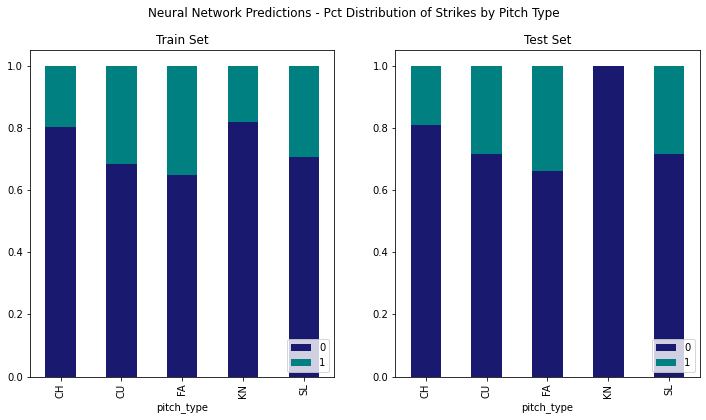

In [228]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
plt.suptitle("Neural Network Predictions - Pct Distribution of Strikes by Pitch Type")

# Train
x_tab_train = pd.crosstab(df_train['pitch_type'], df_train['strike_bool']
                          ,normalize='index')

x_tab_train.plot.bar(stacked=True, ax=ax[0]
                     ,title='Train Set', color=['midnightblue','teal'])
ax[0].legend(loc='lower right')


# Test
x_tab_test = pd.crosstab(df_test_temp['pitch_type']
                         ,df_test_temp['strike_bool_pred']
                         ,normalize='index')

x_tab_test.plot.bar(stacked=True, ax=ax[1]
                    ,title='Test Set', color=['midnightblue','teal'])

#plt.rcParams["legend.loc"] = 'lower right'
ax[1].legend(loc='lower right')

plt.show()

Distribution looks pretty similar. Ignore Knuckleball because there are so few.

Again, assuming these *should* look similar is contigent on the `train` and `test` samples being stratified similarly.

##### Predicted Probabilities

In [114]:
pred_proba = selected_model.predict_proba(holdout_scaled)

73/73 [==============================] - 0s 678us/step


Check sum.

In [115]:
np.sum(pred_proba)

18633.0

In [116]:
np.sum(pred_proba, axis=0)

array([12940.493,  5692.558], dtype=float32)

Quick look at results:

- Look at strike probabilities

In [117]:
pred_proba_strike_only = pred_proba[:, -1]
np.round(pred_proba_strike_only[:10], 3)

array([0.001, 0.   , 0.996, 0.821, 0.999, 0.001, 0.968, 0.   , 1.   ,
       0.008], dtype=float32)

- Put into a `DataFrame` for readability and ease of export to `.csv`

In [118]:
df_strk_prob = pd.concat([pitch_ids, pd.DataFrame(pred_proba_strike_only)], axis=1)
df_strk_prob.columns = ['pitch_id', 'pr_strike']
display(df_strk_prob.head(10))
display(df_strk_prob.tail(100))

,pitch_id,pr_strike
0,4a275ee6-0473-4272-91da-000b8a5f7194,8.751452e-04
1,0f8de36d-2148-4ade-b2f6-003e94c52f79,2.874003e-08
2,0245561a-cb47-4aef-b167-003cbac75013,9.961634e-01
3,47caed4e-8a65-43ee-b577-000f42cd6793,8.207997e-01
4,2b1e1a66-e2c8-47df-b6f1-0038697d893e,9.989308e-01
5,1f04598e-ac36-44fb-9e21-0018dcbae78f,1.069129e-03
6,0b0a030a-8363-401b-95e6-00258ca848c3,9.677808e-01
7,34b4f260-d83a-4d55-99e3-0041283bec27,2.119839e-04
8,044eaf4b-585d-42da-bb31-003e52c4fc03,9.998666e-01
9,23d14cd7-d4ec-4be7-9524-003fee40c05d,8.335888e-03


,pitch_id,pr_strike
18533,f807a4cb-902a-4dc4-afd2-c7b422d9fdbb,5.476022e-02
18534,dbd3511b-3b96-46b7-951a-c7e43bd05bf3,1.077026e-08
18535,d6ba0c8a-0657-422b-b7f8-c7f034760b3c,1.842517e-02
18536,dcb8b207-a5b4-4a35-bc0f-c93e525297e8,1.132429e-02
18537,ddb9630d-d999-4278-adf8-c9da39a1505e,3.182799e-07
...,...,...
18628,ef712401-9764-4221-82df-fd4b642b8145,9.417263e-02
18629,d31df947-88bc-4d6a-9246-fd9cbb99380e,8.378584e-06
18630,dd494b8a-f3a5-48e5-abe7-fe3db431d2fe,1.509786e-04
18631,d938da49-1ad5-4d29-a6b1-fe6adc7b606e,1.162589e-03


In [119]:
df_strk_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18633 entries, 0 to 18632
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pitch_id   18633 non-null  object 
 1   pr_strike  18633 non-null  float32
dtypes: float32(1), object(1)
memory usage: 218.5+ KB


In [120]:
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")
file_class_nm = 'nn_pred_vals_' + str_ts
file_proba_nm = 'nn_pred_proba_' + str_ts
file_proba_stk_nm = 'nn_strike_proba_by_pitch_id_' + str_ts

file_class_path = './predictions/holdout/' + file_class_nm + '.csv'
file_proba_path = './predictions/holdout/' + file_proba_nm + '.csv'
file_proba_stk_path = './predictions/holdout/deliverables/' + file_proba_stk_nm + '.csv'

display(file_class_path)
display(file_proba_path)
display(file_proba_stk_path)

'./predictions/holdout/nn_pred_vals_20220512_0855.csv'

'./predictions/holdout/nn_pred_proba_20220512_0855.csv'

'./predictions/holdout/deliverables/nn_strike_proba_by_pitch_id_20220512_0855.csv'

In [121]:
# save out predicted probabilities

# Versions for personal reference
np.savetxt(file_class_path, pred_classes, delimiter=",")
np.savetxt(file_proba_path, pred_proba, delimiter=",")

# Actual deliverable in desired format
df_strk_prob.to_csv(file_proba_stk_path)

---  
### 3. Predictions - XGBoost<a id='7_xgb_pred'></a>

<span style="font-size:0.5em;"><a href='#7_toc'>Back to TOC</a></span>

---  

#### Make Predictions!

- For completeness we will produce various files for both strike outcomes and probabilities, though we will only deliver the probabilities files.

#### a. Prep `pitch_id`

We will need `pitch_id` so that customers can crosswalk to their datasets, if needed.

In [229]:
pitch_ids = df_test['pitch_id']
display(pitch_ids.head(10))

0    4a275ee6-0473-4272-91da-000b8a5f7194
1    0f8de36d-2148-4ade-b2f6-003e94c52f79
2    0245561a-cb47-4aef-b167-003cbac75013
3    47caed4e-8a65-43ee-b577-000f42cd6793
4    2b1e1a66-e2c8-47df-b6f1-0038697d893e
5    1f04598e-ac36-44fb-9e21-0018dcbae78f
6    0b0a030a-8363-401b-95e6-00258ca848c3
7    34b4f260-d83a-4d55-99e3-0041283bec27
8    044eaf4b-585d-42da-bb31-003e52c4fc03
9    23d14cd7-d4ec-4be7-9524-003fee40c05d
Name: pitch_id, dtype: object

In [230]:
pitch_ids.shape

(18633,)

--- 
#### b. Retrieve and Predict on XGBoost Model

We had previously pickled the candidate XGBoost model. (*Note that file was moved manually the original creation in [this notebook](./06_improved_non_nn_model.ipynb)*)

In [231]:
#%%script echo skipping

best_file_path = ('./models/best_models/classic_2nd_pass_best_model_' +
                  'xgb_20220511_2250.pickle'
                 )
with open(best_file_path, 'rb') as f:
    selected_model = pickle.load(f)

In [232]:
selected_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=4, max_features='sqrt', max_samples=1,
                               min_child_weight=1, min_samples_split=0.38,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=16, num_parallel_tree=1,
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,


In [233]:
pred_classes = selected_model.predict(holdout_scaled)
display(pred_classes.shape)

(18633,)

Quick look at results:

In [234]:
pred_classes[:100]

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [235]:
sum(pred_classes)

5740

**Sniff Test #1:**  
Look at relative ratio of strikes:

Over **test** set:

In [236]:
df_pred = pd.DataFrame(pred_classes)
df_pred.value_counts(normalize=True)

0    0.691944
1    0.308056
dtype: float64

For comparison, relative ratio in **training** data:

In [237]:
df_train = pd.read_pickle('../data/train_enriched.pkl')
df_train['strike_bool'].value_counts(normalize=True)

0    0.686864
1    0.313136
Name: strike_bool, dtype: float64

Fairly close! It could be a _dangerous_ assumption, but based on what we DO know of how the datasets were constructed, the fact that the ratios are so close makes me feel that our results are pretty good.

**Sniff Test #2:**  
I want to see the distribution over pitch type. 

We'll need to use `pitch_type` in the test set. 

In [238]:
df_test_temp = df_test.copy()
df_test_temp['strike_bool_pred'] = df_pred

# viz checks
display(df_test_temp.head())
display(df_test_temp['pitch_type'].value_counts())

# For the purpose of this exercise let's use same pitches as in training set
pitches = list(df_train['pitch_type'].unique())
pitches.sort()
display(pitches)
pit_test_flag = df_test_temp['pitch_type'].isin(pitches)

display(f'Rows before: {df_test_temp.shape[0]}')

df_test_temp = df_test_temp[pit_test_flag]

display(f'Rows after: {df_test_temp.shape[0]}')

,pitch_id,season,game_date,inning,side,run_diff,at_bat_index,pitch_of_ab,batter,pitcher,...,strikes,pitch_speed,px,pz,break_x,break_z,angle_x,angle_z,pitch_type,strike_bool_pred
0,4a275ee6-0473-4272-91da-000b8a5f7194,2021,2021-06-15,7,away,0,47,4,563991,567234,...,2,88.1309,-0.689798,0.880993,-16.171500,-31.5262,-0.261130,8.02184,CH,0
1,0f8de36d-2148-4ade-b2f6-003e94c52f79,2021,2021-05-01,1,home,0,0,4,773351,784900,...,2,93.8505,0.670993,4.807010,12.789200,-15.4120,-1.285440,2.30556,FA,0
2,0245561a-cb47-4aef-b167-003cbac75013,2021,2021-06-29,2,home,0,15,3,578897,587304,...,0,87.1178,0.550363,2.374940,6.324360,-30.0377,-3.152060,7.95176,SL,1
3,47caed4e-8a65-43ee-b577-000f42cd6793,2021,2021-07-19,6,home,8,60,4,561637,529497,...,0,92.9043,0.884750,2.420760,12.111500,-20.9565,0.699183,6.08815,FA,1
4,2b1e1a66-e2c8-47df-b6f1-0038697d893e,2021,2021-04-22,7,home,0,48,1,529059,626939,...,0,86.5579,-0.343300,2.650810,0.996405,-25.6905,-2.418760,6.37698,SL,1


FA    9495
SL    4721
CH    2217
CU    2034
XX     142
AP      19
KN       1
Name: pitch_type, dtype: int64

['CH', 'CU', 'FA', 'KN', 'SL']

'Rows before: 18633'

'Rows after: 18468'

**Show distribution of strikes by pitch, Train vs Test**

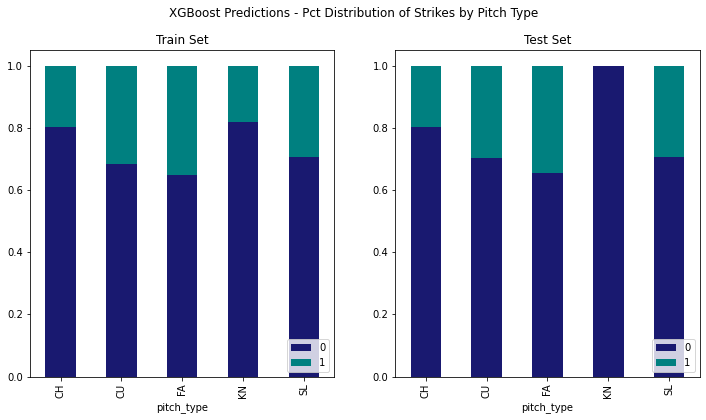

In [239]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
plt.suptitle("XGBoost Predictions - Pct Distribution of Strikes by Pitch Type")

# Train
x_tab_train = pd.crosstab(df_train['pitch_type'], df_train['strike_bool']
                          ,normalize='index')

x_tab_train.plot.bar(stacked=True, ax=ax[0]
                     ,title='Train Set', color=['midnightblue','teal'])
ax[0].legend(loc='lower right')


# Test
x_tab_test = pd.crosstab(df_test_temp['pitch_type']
                         ,df_test_temp['strike_bool_pred']
                         ,normalize='index')

x_tab_test.plot.bar(stacked=True, ax=ax[1]
                    ,title='Test Set', color=['midnightblue','teal'])

#plt.rcParams["legend.loc"] = 'lower right'
ax[1].legend(loc='lower right')

plt.show()

Distribution looks pretty similar. Ignore Knuckleball because there are so few.

Again, assuming these *should* look similar is contigent on the `train` and `test` samples being stratified similarly.

##### Predicted Probabilities

In [131]:
pred_proba = selected_model.predict_proba(holdout_scaled)

Check sum.

In [132]:
np.sum(pred_proba)

18632.998

In [133]:
np.sum(pred_proba, axis=0)

array([12864.388 ,  5768.6123], dtype=float32)

Quick look at results:

- Look at strike probabilities

In [134]:
pred_proba_strike_only = pred_proba[:, -1]
np.round(pred_proba_strike_only[:10], 3)

array([0.001, 0.   , 0.991, 0.68 , 0.994, 0.   , 0.976, 0.   , 0.996,
       0.006], dtype=float32)

- Put into a `DataFrame` for readability and ease of export to `.csv`

In [135]:
df_strk_prob = pd.concat([pitch_ids, pd.DataFrame(pred_proba_strike_only)], axis=1)
df_strk_prob.columns = ['pitch_id', 'pr_strike']
display(df_strk_prob.head(10))
display(df_strk_prob.tail(100))

,pitch_id,pr_strike
0,4a275ee6-0473-4272-91da-000b8a5f7194,0.000739
1,0f8de36d-2148-4ade-b2f6-003e94c52f79,0.000028
2,0245561a-cb47-4aef-b167-003cbac75013,0.991074
3,47caed4e-8a65-43ee-b577-000f42cd6793,0.679768
4,2b1e1a66-e2c8-47df-b6f1-0038697d893e,0.994177
5,1f04598e-ac36-44fb-9e21-0018dcbae78f,0.000057
6,0b0a030a-8363-401b-95e6-00258ca848c3,0.975858
7,34b4f260-d83a-4d55-99e3-0041283bec27,0.000037
8,044eaf4b-585d-42da-bb31-003e52c4fc03,0.995661
9,23d14cd7-d4ec-4be7-9524-003fee40c05d,0.005798


,pitch_id,pr_strike
18533,f807a4cb-902a-4dc4-afd2-c7b422d9fdbb,0.093848
18534,dbd3511b-3b96-46b7-951a-c7e43bd05bf3,0.000001
18535,d6ba0c8a-0657-422b-b7f8-c7f034760b3c,0.059318
18536,dcb8b207-a5b4-4a35-bc0f-c93e525297e8,0.004574
18537,ddb9630d-d999-4278-adf8-c9da39a1505e,0.000055
...,...,...
18628,ef712401-9764-4221-82df-fd4b642b8145,0.046366
18629,d31df947-88bc-4d6a-9246-fd9cbb99380e,0.000562
18630,dd494b8a-f3a5-48e5-abe7-fe3db431d2fe,0.000934
18631,d938da49-1ad5-4d29-a6b1-fe6adc7b606e,0.002152


In [136]:
df_strk_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18633 entries, 0 to 18632
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pitch_id   18633 non-null  object 
 1   pr_strike  18633 non-null  float32
dtypes: float32(1), object(1)
memory usage: 218.5+ KB


In [138]:
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")
file_class_nm = 'xgb_pred_vals_' + str_ts
file_proba_nm = 'xgb_pred_proba_' + str_ts
file_proba_stk_nm = 'xgb_strike_proba_by_pitch_id_' + str_ts

file_class_path = './predictions/holdout/' + file_class_nm + '.csv'
file_proba_path = './predictions/holdout/' + file_proba_nm + '.csv'
file_proba_stk_path = './predictions/holdout/deliverables/' + file_proba_stk_nm + '.csv'

display(file_class_path)
display(file_proba_path)
display(file_proba_stk_path)

'./predictions/holdout/xgb_pred_vals_20220512_0856.csv'

'./predictions/holdout/xgb_pred_proba_20220512_0856.csv'

'./predictions/holdout/deliverables/xgb_strike_proba_by_pitch_id_20220512_0856.csv'

In [139]:
# save out predicted probabilities

# Versions for personal reference
np.savetxt(file_class_path, pred_classes, delimiter=",")
np.savetxt(file_proba_path, pred_proba, delimiter=",")

# Actual deliverable in desired format
df_strk_prob.to_csv(file_proba_stk_path)

---  
### 4. Diagnostics<a id='7_dx'></a>

One thing I'm curious to look at is how much disagreement is there between the two prediction sets, at least by classes (assuming .50 cutoff)?

<span style="font-size:0.5em;"><a href='#7_toc'>Back to TOC</a></span>

In [270]:
nn_path = './predictions/holdout/nn_pred_vals_20220512_0855.csv'
xgb_path = './predictions/holdout/xgb_pred_vals_20220512_0856.csv'

nn_pred = pd.read_csv(nn_path, names=['strike_bool_nn'])
xgb_pred = pd.read_csv(xgb_path, names=['strike_bool_xgb'])


display(f'nn count: {nn_pred.shape[0]:,}')
display(f'xgb count: {xgb_pred.shape[0]:,}')

'nn count: 18,633'

'xgb count: 18,633'

In [260]:
disagree = sum(df_preds['strike_bool_nn'] != df_preds['strike_bool_xgb'])
row_count = nn_pred.shape[0]

In [259]:
display(f'Number of rows that are in disgreement: {disagree}') 

'Number of rows that are in disgreement: 338'

In [264]:
display(f'Percent of rows that are in disgreement: {disagree/row_count:.1%}') 

'Percent of rows that are in disgreement: 1.8%'

This seems to be an acceptable and reasonable result, given that the two models both perform well. In other words, we might conclude they perform well, but not identically so...which makes sense!

---  

<span style="font-size:0.5em;">End of Current Work</span>

<a id='7_the_end'></a>

<span style="font-size:0.5em;"><a href='#7_toc'>Back to TOC</a></span>

-----